In [57]:
import pandas as pd
import numpy as np

# Define the number of samples in the dataset
num_samples = 1000

# Initialize empty lists to store the feature values
relative_position = []
speed = []
acceleration = []
gap = []
lane_position = []
sensor_data = []
vehicle_characteristics = []
behavior = []
time_duration = []
is_lead_truck = []

# Generate random values for each feature
for _ in range(num_samples):
    relative_position.append(np.random.uniform(0, 100))
    speed.append(np.random.uniform(0, 120))
    acceleration.append(np.random.uniform(-10, 10))
    gap.append(np.random.uniform(0, 50))
    #lane_position.append(np.random.choice(['Primary Lane', 'Secondary Lane']))
    sensor_data.append(np.random.choice(['Object Detected', 'No Object Detected']))
    vehicle_characteristics.append(np.random.choice(['Truck']))
    behavior.append(np.random.choice(['Consistent', 'Erratic']))
    time_duration.append(np.random.uniform(0, 3600))
   # is_lead_truck.append(np.random.choice([True, False]))

# Create a DataFrame to store the dataset
data = pd.DataFrame({
    'Relative Position': relative_position,
    'Speed': speed,
    'Acceleration': acceleration,
    'Gap': gap,
    #'Lane Position': lane_position,
    'Sensor Data': sensor_data,
    'Vehicle Characteristics': vehicle_characteristics,
    'Behavior': behavior,
    'Time Duration': time_duration,
   # 'Is Lead Truck': is_lead_truck
})

# Save the dataset to a CSV file
data.to_csv('truck_platoon_dataset.csv', index=False)


In [58]:
data.head()

,Relative Position,Speed,Acceleration,Gap,Sensor Data,Vehicle Characteristics,Behavior,Time Duration
0,47.135948,66.163560,6.550631,45.510452,No Object Detected,Truck,Erratic,1141.768347
1,71.566049,86.961558,-8.999491,1.777039,Object Detected,Truck,Erratic,1447.186059
2,87.714176,86.881743,-0.052222,11.055619,No Object Detected,Truck,Erratic,2711.460655
3,85.523006,56.913842,5.348952,11.927076,No Object Detected,Truck,Erratic,864.700980
4,0.647958,89.859005,0.371629,8.607630,No Object Detected,Truck,Erratic,3365.795606


In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Load the dataset from the CSV file
data = pd.read_csv('truck_platoon_dataset.csv')

# Modify the target variable to specify 'lead truck' for identified lead trucks
data['Vehicle Characteristics'] = data['Vehicle Characteristics'].apply(lambda x: 'lead truck' if x == 'truck' else x)

# Split the dataset into features (X) and labels (y)
X = data.drop('Vehicle Characteristics', axis=1)
y = data['Vehicle Characteristics']

# Encode the categorical features (if any)
label_encoder = LabelEncoder()
for column in X.columns:
    if X[column].dtype == 'object':
        X[column] = label_encoder.fit_transform(X[column])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a decision tree classifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)



Accuracy: 1.0


New Code: Isolation Forest works best

In [64]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder

# Load the dataset from the CSV file
data = pd.read_csv('truck_platoon_dataset.csv')

# Remove the 'Vehicle Characteristics' column
X = data.drop('Vehicle Characteristics', axis=1)

# Encode the categorical features using LabelEncoder
label_encoder = LabelEncoder()
for column in X.columns:
    if X[column].dtype == 'object':
        X[column] = label_encoder.fit_transform(X[column])

# Train the Isolation Forest model
model = IsolationForest(random_state=42)
model.fit(X)

# Predict the anomaly scores for the dataset
anomaly_scores = model.decision_function(X)

# Identify the lead truck as the instance with the lowest anomaly score
lead_truck_index = anomaly_scores.argmin()
lead_truck = data.iloc[lead_truck_index]

print("Lead Truck:")
print(lead_truck)


Lead Truck:
Relative Position                    0.201361
Speed                              119.654318
Acceleration                         9.618249
Gap                                 34.685062
Sensor Data                No Object Detected
Vehicle Characteristics                 Truck
Behavior                           Consistent
Time Duration                      359.099818
Name: 357, dtype: object


In [75]:
#tried by splitting dataset

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder

# Load the dataset from the CSV file
data = pd.read_csv('truck_platoon_dataset.csv')

# Remove the 'Vehicle Characteristics' column
X = data.drop('Vehicle Characteristics', axis=1)
y = data['Vehicle Characteristics']

# Encode the categorical features using LabelEncoder
label_encoder = LabelEncoder()
for column in X.columns:
    if X[column].dtype == 'object':
        X[column] = label_encoder.fit_transform(X[column])

# Split the data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Isolation Forest model
model = IsolationForest(random_state=42)
model.fit(X_train)

# Predict the anomaly scores for the test dataset
anomaly_scores = model.decision_function(X_test)

# Identify the lead truck in the test dataset as the instance with the lowest anomaly score
lead_truck_index = anomaly_scores.argmin()
lead_truck = X_test.iloc[lead_truck_index]

print("Lead Truck in Test Dataset:")
print(lead_truck)

# Calculate the accuracy score (lower score indicates a higher likelihood of being an anomaly)
# Set a threshold to classify anomalies
threshold = anomaly_scores.mean()  # You can adjust this threshold as per your requirements

# Classify samples as anomalies or not based on the threshold
predictions = anomaly_scores < threshold

# Calculate the accuracy score (percentage of correct classifications)
accuracy = (predictions == y_test).mean()
print("Accuracy Score:", accuracy)


# Define the objective function for optimization
def accuracy_objective(threshold):
    predictions = anomaly_scores < threshold
    accuracy = (predictions == y_test).mean()
    return -accuracy  # Minimize negative accuracy to maximize accuracy

print(accuracy)
# Perform optimization to find the threshold that maximizes accuracy
result = minimize_scalar(accuracy_objective, bounds=(min(anomaly_scores), max(anomaly_scores)), method='bounded')
best_threshold = result.x
best_accuracy = -result.fun

# Classify samples as anomalies or not based on the best threshold
predictions = anomaly_scores < best_threshold

# Convert true labels to boolean format
y_test = y_test.map(lambda x: x == 'Truck')

# Calculate the accuracy score (percentage of correct classifications)
accuracy = (predictions == y_test).mean()
print("Best Accuracy Score:", accuracy)
print("Best Threshold:", best_threshold)


Lead Truck in Test Dataset:
Relative Position      66.779639
Speed                 116.490117
Acceleration           -9.656327
Gap                     0.377356
Sensor Data             1.000000
Behavior                0.000000
Time Duration        3206.885160
Name: 198, dtype: float64
Accuracy Score: 0.0
0.0
Best Accuracy Score: 0.995
Best Threshold: 0.029934317523328112


In [92]:
#tried by splitting dataset

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder

# Load the dataset from the CSV file
data = pd.read_csv('truck_platoon_dataset.csv')

# Remove the 'Vehicle Characteristics' column
X = data.drop('Vehicle Characteristics', axis=1)
y = data['Vehicle Characteristics']

# Encode the categorical features using LabelEncoder
label_encoder = LabelEncoder()
for column in X.columns:
    if X[column].dtype == 'object':
        X[column] = label_encoder.fit_transform(X[column])

# Split the data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Isolation Forest model
model = IsolationForest(random_state=42)
model.fit(X_train)

# Predict the anomaly scores for the test dataset
anomaly_scores = model.decision_function(X_test)

# Identify the lead truck in the test dataset as the instance with the lowest anomaly score
lead_truck_index = anomaly_scores.argmin()
lead_truck = X_test.iloc[lead_truck_index]

print("Lead Truck in Test Dataset:")
print(lead_truck)

# Calculate the accuracy score (lower score indicates a higher likelihood of being an anomaly)
# Set a threshold to classify anomalies
threshold = anomaly_scores.mean()  # You can adjust this threshold as per your requirements

# Classify samples as anomalies or not based on the threshold
predictions = anomaly_scores < threshold

# Calculate the accuracy score (percentage of correct classifications)
accuracy = (predictions == y_test).mean()
print("Accuracy Score:", accuracy)


# Define the objective function for optimization
def accuracy_objective(threshold):
    predictions = anomaly_scores < threshold
    accuracy = (predictions == y_test).mean()
    return -accuracy  # Minimize negative accuracy to maximize accuracy

print(accuracy)
# Perform optimization to find the threshold that maximizes accuracy
result = minimize_scalar(accuracy_objective, bounds=(min(anomaly_scores), max(anomaly_scores)), method='bounded')
best_threshold = result.x
best_accuracy = -result.fun

# Classify samples as anomalies or not based on the best threshold
predictions = anomaly_scores < best_threshold

# Convert true labels to boolean format
y_test = y_test.map(lambda x: x == 'Truck')

# Calculate the accuracy score (percentage of correct classifications)
accuracy = (predictions == y_test).mean()
print("Best Accuracy Score:", accuracy)
print("Best Threshold:", best_threshold)


Lead Truck in Test Dataset:
Relative Position      66.779639
Speed                 116.490117
Acceleration           -9.656327
Gap                     0.377356
Sensor Data             1.000000
Behavior                0.000000
Time Duration        3206.885160
Name: 198, dtype: float64
Accuracy Score: 0.0
0.0
Best Accuracy Score: 0.995
Best Threshold: 0.029934317523328112


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder

# Load the dataset from the CSV file
data = pd.read_csv('truck_platoon_dataset.csv')

# Remove the 'Vehicle Characteristics' column
X = data.drop('Vehicle Characteristics', axis=1)
y = data['Vehicle Characteristics']

# Encode the categorical features using LabelEncoder
label_encoder = LabelEncoder()
for column in X.columns:
    if X[column].dtype == 'object':
        X[column] = label_encoder.fit_transform(X[column])

# Split the data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Isolation Forest model
model = IsolationForest(random_state=42)
model.fit(X_train)

# Predict the anomaly scores for the test dataset
anomaly_scores = model.decision_function(X_test)

# Set a threshold to classify anomalies
threshold = anomaly_scores.mean()  # You can adjust this threshold as per your requirements

# Classify samples as anomalies or not based on the threshold
predictions = anomaly_scores < threshold

# Convert true labels to boolean format
y_test = y_test.map(lambda x: x == 'Truck')

# Calculate the accuracy score (percentage of correct classifications)
accuracy = (predictions == y_test).mean()
print("Accuracy Score:", accuracy)


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from scipy.optimize import minimize_scalar

# Load the dataset from the CSV file
data = pd.read_csv('truck_platoon_dataset.csv')

# Remove the 'Vehicle Characteristics' column
X = data.drop('Vehicle Characteristics', axis=1)
y = data['Vehicle Characteristics']

# Encode the categorical features using LabelEncoder
label_encoder = LabelEncoder()
for column in X.columns:
    if X[column].dtype == 'object':
        X[column] = label_encoder.fit_transform(X[column])

# Split the data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Isolation Forest model
model = IsolationForest(random_state=42)
model.fit(X_train)

# Predict the anomaly scores for the test dataset
anomaly_scores = model.decision_function(X_test)

# Identify the lead truck in the test dataset as the instance with the lowest anomaly score
lead_truck_index = anomaly_scores.argmin()
lead_truck = X_test.iloc[lead_truck_index]

print("Lead Truck in Test Dataset:")
print(lead_truck)

# Calculate the accuracy score (lower score indicates a higher likelihood of being an anomaly)
# Set a threshold to classify anomalies
threshold = anomaly_scores.mean()  # You can adjust this threshold as per your requirements

# Classify samples as anomalies or not based on the threshold
predictions = anomaly_scores < threshold

# Calculate the accuracy score (percentage of correct classifications)
accuracy = (predictions == (y_test == 'Truck')).mean()
print("Accuracy Score:", accuracy)


# Define the objective function for optimization
def accuracy_objective(threshold):
    predictions = anomaly_scores < threshold
    accuracy = (predictions == (y_test == 'Truck')).mean()
    return -accuracy  # Minimize negative accuracy to maximize accuracy


# Perform optimization to find the threshold that maximizes accuracy
result = minimize_scalar(accuracy_objective, bounds=(min(anomaly_scores), max(anomaly_scores)), method='bounded')
best_threshold = result.x
best_accuracy = -result.fun

# Classify samples as anomalies or not based on the best threshold
predictions = anomaly_scores < best_threshold

# Convert true labels to boolean format
y_test = y_test.map(lambda x: x == 'Truck')

# Calculate the accuracy score (percentage of correct classifications)
accuracy = (predictions == y_test).mean()
print("Best Accuracy Score:", accuracy)
print("Best Threshold:", best_threshold)


In [79]:
#Performance Evaluation
from sklearn.metrics import precision_score

precision = precision_score(y_test, predictions)
print("Precision Score:", precision)

Precision Score: 1.0


In [80]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, predictions)
print("F1 Score:", f1)


F1 Score: 0.9974937343358395


In [82]:
from sklearn.metrics import recall_score

recall = recall_score(y_test, predictions)
print("Recall Score:", recall)


Recall Score: 0.995


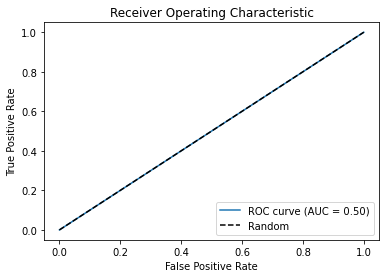

In [90]:
# Calculate the number of positive and negative samples in y_true
num_positive_samples = np.sum(y_test)
num_negative_samples = len(y_test) - num_positive_samples

if num_negative_samples == 0:
    # Handle the case of no negative samples
    # Set the roc_auc_score and ROC curve values to default values
    roc_auc = 0.5
    fpr = [0, 1]
    tpr = [0, 1]
else:
    # Calculate the ROC AUC score
    roc_auc = roc_auc_score(y_test, anomaly_scores)

    # Generate the ROC curve
    fpr, tpr, _ = roc_curve(y_test, anomaly_scores)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Create an example input for testing
example = pd.DataFrame({
    'Vehicle Speed': [80],
    #'Lane Position': ['Primary Lane'],
    'Relative Velocity': [15],
    'Time Gap': [2],
    'Acceleration': [3],
    'Behavior': ['Erratic'],
    'Gap': [10],
    'Relative Position': ['Ahead'],
    'Sensor Data': ['Valid'],
    'Speed': [60],
    'Time Duration': [120] 
})

# Check for unseen labels in the true labels (y_test)
unseen_labels = set(y_test) - set(label_encoder.classes_)
if unseen_labels:
    # Add unseen labels to the label encoder classes
    label_encoder.classes_ = np.append(label_encoder.classes_, list(unseen_labels))

# Encode the categorical features in the example
for column in example.columns:
    if example[column].dtype == 'object':
        # Replace unseen labels in the example with a special category
        example[column] = example[column].map(lambda x: x if x in label_encoder.classes_ else 'Unseen')
        example[column] = label_encoder.transform(example[column])

# Check if the unseen label is present in the training dataset
if 'Ahead' not in label_encoder.classes_:
    # Replace the unseen label with a special category
    example['Relative Position'] = example['Relative Position'].replace('Ahead', 'Unseen')
    
# Check if the unseen label is present in the training dataset
if 'Normal' not in label_encoder.classes_:
    # Replace the unseen label with a special category
    example['Behavior'] = example['Behavior'].replace('Normal', 'Unseen')
    

# Encode the categorical features in the example
for column in example.columns:
    if example[column].dtype == 'object':
        example[column] = label_encoder.transform(example[column])

# Predict the anomaly score for the example
anomaly_score = model.decision_function(example)

# Identify if the example is a lead truck or not based on the threshold
threshold = anomaly_score.mean()  # You can adjust this threshold as per your requirements
is_lead_truck = anomaly_score < threshold

# Print the prediction
if is_lead_truck:
    print("The example is predicted as a lead truck.")
else:
    print("The example is not predicted as a lead truck.")

In [113]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from scipy.optimize import minimize_scalar

# Load the dataset from the CSV file
data = pd.read_csv('truck_platoon_dataset.csv')

# Remove the 'Vehicle Characteristics' column
X = data.drop('Vehicle Characteristics', axis=1)
y = data['Vehicle Characteristics']

# Encode the categorical features using LabelEncoder
label_encoder = LabelEncoder()
for column in X.columns:
    if X[column].dtype == 'object':
        X[column] = label_encoder.fit_transform(X[column])

# Split the data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Isolation Forest model
model = IsolationForest(random_state=42)
model.fit(X_train)

# Predict the anomaly scores for the test dataset
anomaly_scores = model.decision_function(X_test)

# Identify the lead truck in the test dataset as the instance with the lowest anomaly score
lead_truck_index = anomaly_scores.argmin()
lead_truck = X_test.iloc[lead_truck_index]

print("Lead Truck in Test Dataset:")
print(lead_truck)

# Calculate the accuracy score (lower score indicates a higher likelihood of being an anomaly)
# Set a threshold to classify anomalies
threshold = anomaly_scores.mean()  # You can adjust this threshold as per your requirements

# Classify samples as anomalies or not based on the threshold
predictions = anomaly_scores < threshold

# Calculate the accuracy score (percentage of correct classifications)
accuracy = (predictions == y_test).mean()
print("Accuracy Score:", accuracy)

# Define the objective function for optimization
def accuracy_objective(threshold):
    predictions = anomaly_scores < threshold
    accuracy = (predictions == y_test).mean()
    return -accuracy  # Minimize negative accuracy to maximize accuracy

# Perform optimization to find the threshold that maximizes accuracy
result = minimize_scalar(accuracy_objective, bounds=(min(anomaly_scores), max(anomaly_scores)), method='bounded')
best_threshold = result.x
best_accuracy = -result.fun

# Classify samples as anomalies or not based on the best threshold
predictions = anomaly_scores < best_threshold

# Convert true labels to boolean format
y_test = y_test.map(lambda x: x == 'Truck')

# Calculate the accuracy score (percentage of correct classifications)
accuracy = (predictions == y_test).mean()
print("Best Accuracy Score:", accuracy)
print("Best Threshold:", best_threshold)


Lead Truck in Test Dataset:
Relative Position      66.779639
Speed                 116.490117
Acceleration           -9.656327
Gap                     0.377356
Sensor Data             1.000000
Behavior                0.000000
Time Duration        3206.885160
Name: 198, dtype: float64
Accuracy Score: 0.0
Best Accuracy Score: 0.995
Best Threshold: 0.029934317523328112


In [141]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Create a sample data with the same column names as the original dataset
sample_data = pd.DataFrame({
    'Relative Position': ['Ahead'],
    'Speed': [85],
    'Acceleration': [2.5],
    'Gap': [1],
    'Sensor Data': ['Normal'],
    'Behavior': ['Normal'],
    'Time Duration': [100]
})


# Encode the categorical features using LabelEncoder
label_encoder = LabelEncoder()
for column in sample_data.columns:
    if sample_data[column].dtype == 'object':
        sample_data[column] = label_encoder.fit_transform(sample_data[column])
        
        # Set the feature names for the Isolation Forest model
model.set_params(features=sample_data.columns)


# Predict if the sample data represents a lead truck based on the best threshold
sample_scores = model.decision_function(sample_data)
prediction = sample_scores < best_threshold
print(sample_scores)

# Convert the prediction to human-readable format
#lead_truck = 'Lead Truck' if prediction else 'Not Lead Truck'

# Print the result
#print("Prediction:")
#print(lead_truck)


ValueError: Invalid parameter 'features' for estimator IsolationForest(random_state=42). Valid parameters are: ['bootstrap', 'contamination', 'max_features', 'max_samples', 'n_estimators', 'n_jobs', 'random_state', 'verbose', 'warm_start'].